In [3]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00


In [4]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.4.0+cu121
tiktoken version: 0.7.0


# 2.1 Understanding word embeddings

There are many form of embedding ,  we are currently focus on text embeddings


- LLMs work with embeddings in high-dimensional spaces (i.e., thousands of dimensions)
- Since we can't visualize such high-dimensional spaces (we humans think in 1, 2, or 3 dimensions), the figure below illustrates a 2-dimensional embedding space

# Tokenizing Text

In [5]:
import os
import urllib.request

if not os.path.exists("text.txt"):
    url = ("https://github.com/SURUJ-KALITA/Pytorch-/blob/main/text.txt")
    file_path = "text.txt"
    urllib.request.urlretrieve(url, file_path)

In [6]:
with open("text.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


# - The goal is to tokenize and embed this text for an LLM
- Let's develop a simple tokenizer based on some simple sample text that we can then later apply to the text above
- The following regular expression will split on whitespaces

In [9]:
import re

text = "Hello, PLAY this side . This, is a test. first test "
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'PLAY', ' ', 'this', ' ', 'side', ' ', '.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.', ' ', 'first', ' ', 'test', ' ', '']


 We don't only want to split on whitespaces but also commas and periods, so let's modify the regular expression to do that as well

In [10]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'PLAY', ' ', 'this', ' ', 'side', ' ', '', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '', ' ', 'first', ' ', 'test', ' ', '']


We are going to remove the empty strings

In [11]:
# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'PLAY', 'this', 'side', '.', 'This', ',', 'is', 'a', 'test', '.', 'first', 'test']


In [12]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


# - This is pretty good, and we are now ready to apply this tokenization to the raw text

In [13]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


# Let's calculate the total number of tokens

In [14]:
print(len(preprocessed))

4690


# Converting tokens into token IDs

In [15]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


In [16]:
vocab = {token:integer for integer,token in enumerate(all_words)}

# Below are the first 50 entries in this vocabulary:

In [17]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [18]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

# - The `encode` function turns text into token IDs
- The `decode` function turns token IDs back into text

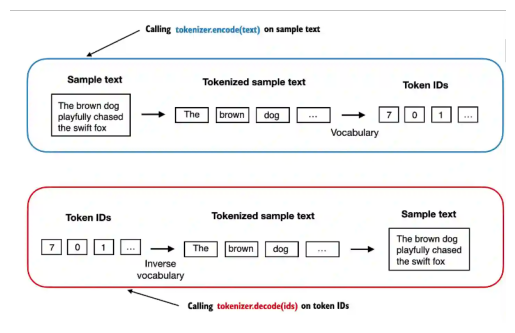

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/tokenid.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

# This phrase will show error as there is no line of text with that phrases

In [23]:
# tokenizer = SimpleTokenizerV1(vocab)

# text = """"hey man play thisnside ."""
# ids = tokenizer.encode(text)
# print(ids)

In [24]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


# We can decode the integers back into text

In [25]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [26]:
tokenizer.decode(tokenizer.encode(text))

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

#Adding special context tokens

# - Some tokenizers use special tokens to help the LLM with additional context
- Some of these special tokens are
  - `[BOS]` (beginning of sequence) marks the beginning of text
  - `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
  - `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- `[UNK]` to represent words that are not included in the vocabulary

- Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity
- The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above
- GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)
- GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section



- Let's see what happens if we tokenize the following text:

In [27]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

# - The above produces an error because the word "Hello" is not contained in the vocabulary
- To deal with such cases, we can add special tokens like `"<|unk|>"` to the vocabulary to represent unknown words
- Since we are already extending the vocabulary, let's add another token called `"<|endoftext|>"` which is used in GPT-2 training to denote the end of a text (and it's also used between concatenated text, like if our training datasets consists of multiple articles, books, etc.)

In [28]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [29]:
len(vocab.items())

1132

In [30]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [31]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

# Let's try to tokenize text with the modified tokenizer:

In [32]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like PLAY?"
text2 = "Is this the best way to learn AI ."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like PLAY? <|endoftext|> Is this the best way to learn AI .


In [33]:
tokenizer.encode(text)

[1131,
 5,
 355,
 1126,
 628,
 1131,
 10,
 1130,
 1131,
 999,
 988,
 1131,
 1083,
 1016,
 1131,
 1131,
 7]

In [34]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like <|unk|>? <|endoftext|> <|unk|> this the <|unk|> way to <|unk|> <|unk|>.'

# GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges

In [35]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.7.0


In [36]:
tokenizer = tiktoken.get_encoding("gpt2")

In [37]:
text = (
    "Hello, do you like play? <|endoftext|> Is this the best wauy to learn AI ."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 711, 30, 220, 50256, 1148, 428, 262, 1266, 266, 559, 88, 284, 2193, 9552, 764]


In [38]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like play? <|endoftext|> Is this the best wauy to learn AI .


# Data sampling with a sliding window

# - We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

In [39]:
with open("text.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


# - For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

In [40]:
enc_sample = enc_text[50:]

In [41]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [42]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [43]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [48]:
!pip install torch
# Install the PyTorch library

# We will take care of the next-word prediction in a later upcoming videos  after we covered the attention machanism

In [56]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [57]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [58]:
with open("text.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [59]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [60]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


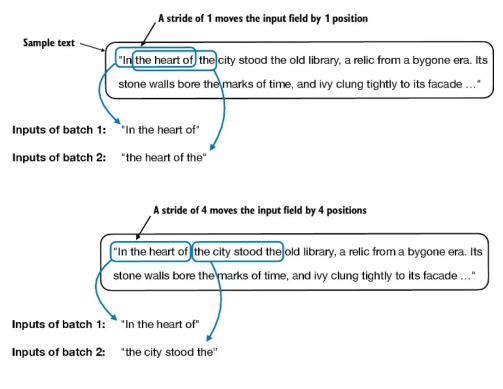

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/strides.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In [63]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


# Creating token embeddings

In [64]:
input_ids = torch.tensor([2, 3, 5, 1])

# - For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [65]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [66]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [67]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


#Encoding word positionsNew Section

In [68]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

# - If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector
- If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:

In [69]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [70]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [71]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


# GPT-2 uses absolute position embeddings, so we just create another embedding layer

In [72]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [73]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


# - To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [75]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


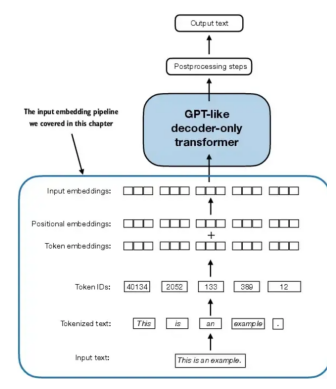

In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/gpt.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

# WE WILL TRAINED LLM MODEL IN THE LATER SECTION OF THE VIDEO TILL THEN STAY TUNED AND GETT THE BASICS CLEAR FOR FUTURE READY

In [ ]:
#####################################
